# 1. Introduction

This is a lab for experimenting with trend-following ideas and techniques.  It includes the following features:

1. Data: downloads historical price data from various sources as input to the experiments.  It also simulates price data with various models to test different strategies.
1. `tr` class: a class for trading strategies upon a single asset.
1. `po` class: a class for portfolio evaluation: select assets, excecute trading strategies and evaluate performance.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pickle
import itertools
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [12, 4]

import ipyparallel as ipp

import quandl

In [37]:
# Utils
def dict_list_to_DataFrame(dl): 
    dl = [{k: [i] for k, i in d.items()} for d in dl]
    out = pd.concat([DataFrame.from_dict(d) for d in dl], sort=False)
    return out

def plot_prices(prices, name=''):
    fig, ax = plt.subplots()
    ax.plot(prices.Open)
    ax.plot(prices.High)
    ax.plot(prices.Low)
    ax.plot(prices.Close)
    ax.axhline(0, color='grey', lw=2, alpha=0.75)
    ax.set_title(name)
    ax.legend()



# 2. Data

The main sources of data are `Quandl`, `Cryptocompare` and `Yahoo Finance`.

## Quandl

In [6]:
api_key = open(file='quandl_api').read().replace('\n', '')
quandl.ApiConfig.api_key = api_key

In [7]:
QUANDL_PATH = 'input/Quandl/'
# ! ls {QUANDL_PATH}
print(os.listdir(QUANDL_PATH))

['SCF.csv', 'SCF.xlsx', 'XASE.csv', 'XASE.pickle', 'XBOM.csv', 'XBOM.pickle', 'XHKG.csv', 'XHKG.pickle', 'XJPX.csv', 'XLON.csv', 'XLON.pickle', 'XNAS.csv', 'XNAS.pickle', 'XNSE.csv', 'XNSE.pickle', 'XNYS.csv', 'XNYS.pickle', 'XSES.csv', 'XSES.pickle', 'XSHE.csv', 'XSHE.pickle', 'XSHG.csv', 'XSHG.pickle', 'XTSE.csv', 'XTSE.pickle', 'XTSX.csv', 'XTSX.pickle']


In [8]:
# Free sample tickers from Exchange Data International
QUANDL_FREE_SAMPLES_EDI = {
    # https://www.quandl.com/data/XNAS-NASDAQ-Stock-Market-Prices
    'XNAS': ['AAL', 'AAME', 'AAON', 'AAPL', 'AAXJ', 'ABAC', 'ABAX',
             'ABCO', 'ABG', 'ABM', 'ABTL', 'ACET', 'ACIW', 'ACLS', 'ACNB'],
    # https://www.quandl.com/data/XBOM-Bombay-Stock-Exchange-Prices
    'XBOM': ['500002', '500003', '500008', '500010', '500012',
             '500013', '500020', '500023', '500024', '500027',
             '500031', '500032', '500038', '500039', '500040'],
    # https://www.quandl.com/data/XTSE-Toronto-Stock-Exchange-Prices
    'XTSE': ['AAB', 'ABT', 'ABX', 'ACD', 'ACQ', 'AEM', 'AFN', 'AGT',
             'AGU', 'AIF', 'ALA', 'ALB', 'ALC', 'ALO', 'AND'],
    # https://www.quandl.com/data/XSHG-Shanghai-Stock-Exchange-Prices
    'XSHG' : ['600000', '600004', '600006', '600007', '600009',
              '600010', '600011', '600012', '600015', '600016',
              '600017', '600019', '600020', '600021', '600026'],
    # https://www.quandl.com/data/XLON-London-Stock-Exchange-Prices
    'XLON': ['AAIF', 'AAL', 'AAS', 'ABBY', 'ABC', 'ABF', 'ADIG', 
             'ADM', 'ADT', 'AEFS', 'AEO', 'AEP', 'AFN', 'AFS', 'AGK'],
    # https://www.quandl.com/data/XSES-Singapore-Exchange-Prices
    'XSES': ['1B6', '1C0', 'A04', 'A05', 'AFC', 'AGS', 'AUE', 'AVX', 
             'BBW', 'BCD', 'BCV', 'BCX',  'BCY', 'BEC', 'BESU'],
    # https://www.quandl.com/data/XNYS-New-York-Stock-Exchange-Prices
    'XNYS': ['A', 'AAT', 'AB', 'ABB', 'ABBV', 'ABC', 'ABEV', 'ABG', 
             'ABM', 'ABR', 'ABT', 'ABX', 'ACC', 'ADC', 'ADM'],
    # https://www.quandl.com/data/XHKG-Hong-Kong-Stock-Exchange-Prices
    'XHKG': ['00002', '00003', '00004', '00005', '00006',
             '00008', '00010', '00011', '00012', '00014',
             '00015', '00016', '00017', '00018', '00019'],
    # https://www.quandl.com/data/XASE-NYSE-MKT-AMEX-Prices
    'XASE': ['ABE', 'ACU', 'ACY', 'ADK', 'AE',  'AMS', 'ARNC_P',
             'BAA', 'BDL', 'BFY', 'BHB', 'BHV', 'BLE', 'BLJ', 'BTI'],
    # https://www.quandl.com/data/XNSE-National-Stock-Exchange-of-India-Prices
    'XNSE': ['ABB', 'ACC', 'ACE', 'ADSL', 'AFL', 'ALICON',
             'BAJAJ_AUTO', 'BASF', 'BASML', 'BBL', 'BEL',
             'BEPL, BHEL', 'BIL', 'BIOCON'],
    # https://www.quandl.com/data/XTSX-Toronto-Ventures-Stock-Exchange-Prices
    'XTSX': ['ABI', 'ABN', 'ADD', 'ADK', 'ADL', 'AFCC', 'AFM', 'AGD', 
             'AGO', 'AHR', 'AIIM', 'ALT', 'ALZ', 'AME', 'AMK'],
    # https://www.quandl.com/data/XSHE-Shenzhen-Stock-Exchange-Prices
    'XSHE': ['200011', '200012', '200018', '200025', '200026',
             '200055', '200056', '200413', '200418', '200488',
             '200521', '200530', '200539', '200541', '200550'],
    # https://www.quandl.com/data/XJPX-Japan-Exchange-Group-Prices/documentation/coverage
    'XJPX': ['13010', '13050', '13060', '13080', '13100', '13110', 
             '13200', '13290', '13300', '13320', '13430', '13440', 
             '13450', '13480', '13760']
}

In [9]:
# xjpx_df = DataFrame(data = np.arange(len(QUANDL_FREE_SAMPLES_EDI['XJPX'])),
#                     index=['XJPX/' + i for i in QUANDL_FREE_SAMPLES_EDI['XJPX']])
# xjpx_df.to_csv(path_or_buf='Input/Quandl/XJPX.csv', header=False)

In [10]:
def saf_quandl_get(dataset, **kwargs):
    try:
        return quandl.get(dataset, **kwargs)
    except:
        return None


def get_quandl_edi(exchanges = 'XNAS', free=True, download=False, flatten=True, verbose=False):
    """
    Downloads price series from Quandl vendor Exchange Data International
    
    Parameters
    ----------
    exchanges : List with names of the exchanges from which to download prices.
    free : If True, only free sample prices are downloaded.
    download : 
        If True, downloads the prices from quandl.  
        If False, looks for previously downloaded results in the QUANDL_PATH folder.
    verbose : If True, prints downloaded tickers.
    flatten: If True, returns a flattened dict with the results.
    
    Returns
    -------
    out : a dict or dict of dicts, of pandas DataFrame for each ticker.
    """
    
    out = dict()
    
    if download:
        for x in exchanges:
            
            prices = pd.read_csv(QUANDL_PATH + x + '.csv', names=['Ticker', 'Desc.'])
            free_sample = QUANDL_FREE_SAMPLES_EDI[x]
            which_free = [re.search('|'.join(free_sample), t) is not None and re.search('_UADJ', t) is None
                          for t in prices['Ticker']]
            if free: 
                prices = prices[which_free]
                
            if verbose:
                print('Downloading prices from', x, '...')
                
            out[x] = {t: saf_quandl_get(t) for t in prices['Ticker']}
            out[x] = {k: i for k, i in out[x].items() if i is not None}
            
            with open(QUANDL_PATH + x + '.pickle', 'wb') as f:
                pickle.dump(out[x], f, pickle.HIGHEST_PROTOCOL)
            
            if verbose:
                print(list(out[x].keys()))
    
    else:
        for x in exchanges:
            try:
                with open(QUANDL_PATH + x + '.pickle', 'rb') as f:
                    out[x] = pickle.load(f)
            except:
                pass
    
    if flatten:
        out = {k: i for x in out.keys() for k, i in out[x].items()}
    
    out = {k: i[['Open', 'High', 'Low', 'Close', 'Volume']] for k, i in out.items()}

    return out

# prices = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()), download=True, verbose=True)

In [11]:
prices_dict = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()))
print(list(prices_dict.keys()))

['XNAS/AAXJ', 'XNAS/AAON', 'XNAS/ABAX', 'XNAS/ABM', 'XNAS/ACET', 'XNAS/ACNB', 'XNAS/AAPL', 'XNAS/AAME', 'XNAS/ACLS', 'XNAS/AAL', 'XNAS/ABCO', 'XNAS/ABG', 'XNAS/ABAC', 'XNAS/ACIW', 'XBOM/500003', 'XBOM/500008', 'XBOM/500012', 'XBOM/500013', 'XBOM/500002', 'XBOM/500023', 'XBOM/500024', 'XBOM/500027', 'XBOM/500031', 'XBOM/500032', 'XBOM/500038', 'XBOM/500039', 'XBOM/500020', 'XBOM/500040', 'XBOM/500010', 'XTSE/AND', 'XTSE/AFN', 'XTSE/AGT', 'XTSE/ACQ', 'XTSE/ALA', 'XTSE/AIF', 'XTSE/ALB', 'XTSE/ALO', 'XTSE/ABT', 'XTSE/ACD', 'XTSE/AEM', 'XTSE/AGU', 'XTSE/ALC', 'XTSE/ABX', 'XTSE/AAB', 'XSHG/600020', 'XSHG/600015', 'XSHG/600021', 'XSHG/600019', 'XSHG/600009', 'XSHG/600016', 'XSHG/600007', 'XSHG/600000', 'XSHG/600006', 'XSHG/600017', 'XSHG/600011', 'XSHG/600010', 'XSHG/600026', 'XSHG/600012', 'XSHG/600004', 'XLON/ADM', 'XLON/ABC', 'XLON/AFS', 'XLON/AAIF', 'XLON/ADT', 'XLON/AEFS', 'XLON/AAS', 'XLON/AFN', 'XLON/AGK', 'XLON/AAL', 'XLON/AEP', 'XLON/ABF', 'XLON/ADIG', 'XLON/ABBY', 'XLON/AEO', 'XSES/

j: 40  -  XTSE/AGU


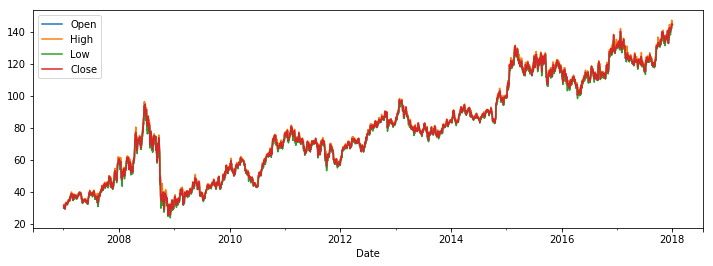

In [12]:
j = np.random.choice(len(prices_dict) - 1)
ticker_j = list(prices_dict.keys())[j]
print('j:', j, ' - ', ticker_j)
prices_dict[ticker_j][['Open', 'High', 'Low', 'Close']].plot()

In [13]:
prices_dict[ticker_j].head()

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-02,30.585574,31.764817,30.062389,31.482463,132324.0
2007-01-03,31.474159,32.288003,31.017410,31.515682,491163.0
2007-01-04,31.723295,31.881081,30.826406,30.984192,343714.0
2007-01-05,31.183500,31.183500,29.946126,29.962735,181214.0
2007-01-08,29.771731,30.427788,29.771731,30.195262,258454.0


## Cryptocompare

## Yahoo Finance

## Data pre-processing

* OHLC: open and close within [low, high].

# 3. Trading Strategies

## 3.1 Definitions

In [14]:
from trading_strategies import *

## 3.2 Trading Tribe example

Here, we reproduce Ed Sykota's trading tribe [example](http://www.seykota.com/tribe/tsp/SR/SYS_SR_140-20_05_v_15/index.htm) on a Support and Resistance trading system.

In [15]:
price = pd.read_csv(filepath_or_buffer='test/Seykota GC----C.csv', header=None,
                   names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Interest'], 
                   index_col=0)
price.index = [datetime.strptime(str(i), '%Y%m%d') for i in price.index.values]

In [16]:
%%time
rs_tr = RS_Trading_Strategy(price, equity=1e6, position_step=1e2,
                            days_fast=20, days_slow=140, name='Comex Gold')
rs_tr.excecute(warmup=20)

Wall time: 303 ms


In [17]:
rs_tr.performance
# rs_tr.get_state()
# rs_tr.get_trades()
# rs_tr.get_equity()

{'Years': 30.745367192862044,
 'Ratio': 2.5855,
 'ICAGR': 0.03089632681552998,
 'Max_Drawdown': 0.40774762925090646,
 'Bliss': 0.07577316113962738,
 'Volatility': 0.160627736025579,
 'Lake_Ratio': 0.17595887397049154,
 'Sea_Ratio': 0.3073924855686487}

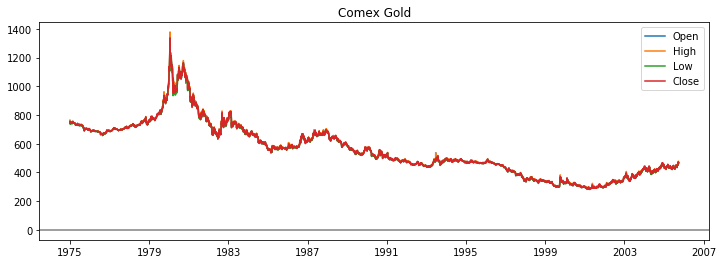

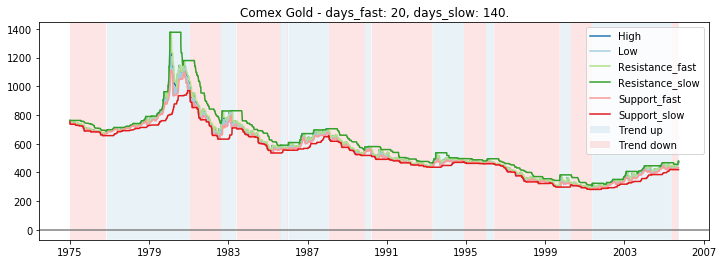

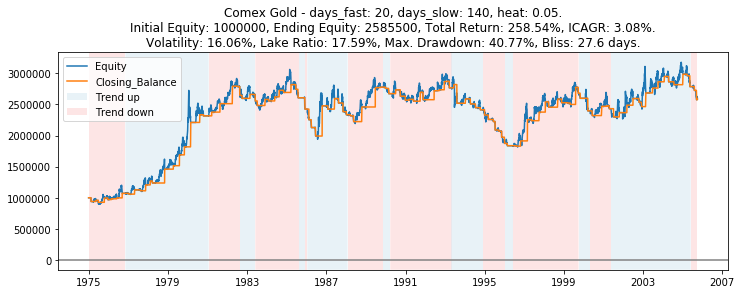

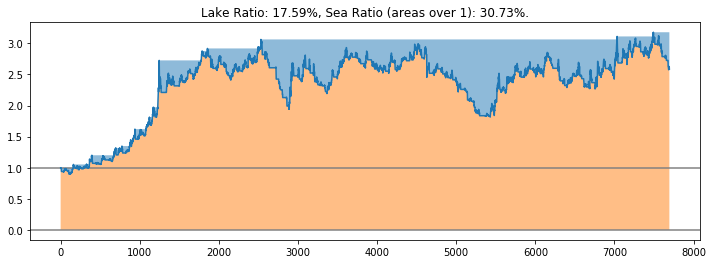

In [18]:
rs_tr.plot_prices()
rs_tr.plot_state()
rs_tr.plot_equity()
rs_tr.plot_lake_ratio()

## 3.3 With a random asset

* TO DO: curate series. Eg.:
    * XNAS/AAPL
    * XTSX/AMK
    * XTSE/ACD
    * XTSX/ADK
    * XTSX/ALZ
    * XTSX/ADK
    * XSES/A04
    * XTSX/AHR

In [19]:
j = np.random.choice(len(prices_dict) - 1)
ticker_j = list(prices_dict)[j]; print(ticker_j, '-', len(prices_dict[ticker_j]), 'days.')
pr_j = prices_dict[ticker_j]

XNYS/AB - 2988 days.


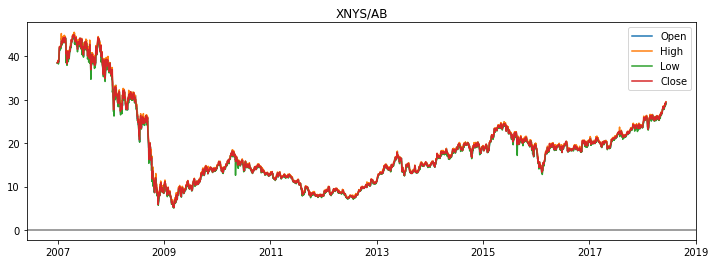

In [20]:
plot_prices(pr_j, ticker_j)

In [21]:
rs_j = RS_Trading_Strategy(pr_j, equity=1e6, days_fast=40, days_slow=120, name=str(j) + ' - ' + ticker_j)
rs_j.excecute(warmup=0.05)

In [22]:
rs_j.performance

{'Years': 10.910089224433769,
 'Ratio': 1.2401936434000005,
 'ICAGR': 0.01973105141750508,
 'Max_Drawdown': 0.24432005876942042,
 'Bliss': 0.08075903188991315,
 'Volatility': 0.10072888213280272,
 'Lake_Ratio': 0.08417326143011394,
 'Sea_Ratio': 0.5036328205021293}

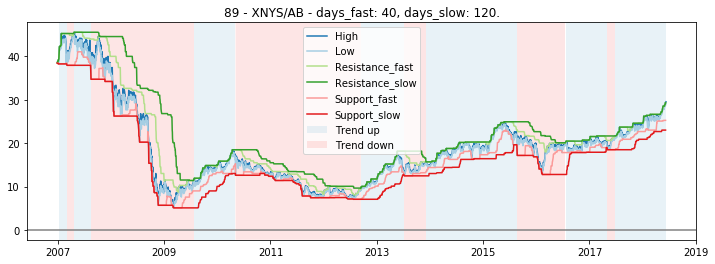

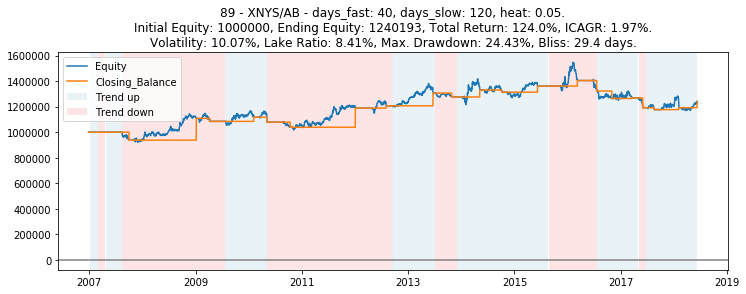

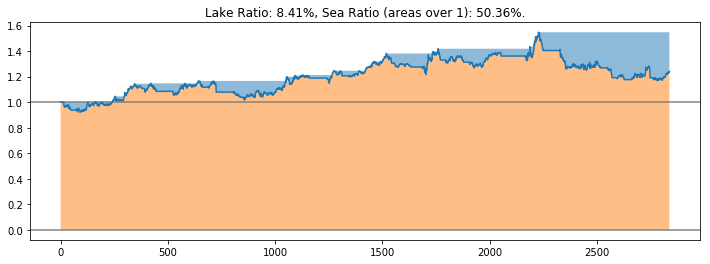

In [23]:
rs_j.plot_state()
rs_j.plot_equity()
rs_j.plot_lake_ratio()

### 3.3.1 Optimizing hyper parameters

#### Grid Search

In [24]:
def grid_search(price_df, name="",
                min_days=20, max_days=400, step=20, min_dif=50,
                warmup=None, tr_size=0.5, heat=0.05, equity=1e6,
                return_df=True):
        
    slow = np.arange(min_days, max_days, step)
    fast = np.arange(min_days, max_days, step)

    res_train = []
    res_val = []
    for s, f in itertools.product(slow, fast):
        if f > (s - 50): 
            continue
        else:
            # Training
            if warmup is None:
                warmup = s
            
            rs_train = RS_Trading_Strategy(price_df, equity=equity, heat=heat,
                                           days_fast=f, 
                                           days_slow=s,
                                           name=name)
            rs_train.excecute(warmup=warmup, end = tr_size)
            res_train.append({'Slow': s, 'Fast': f, 'Type': 'train', **rs_train.performance})

            # Validation
            rs_val = RS_Trading_Strategy(price_df, equity=equity, heat=heat,
                                         days_fast=f, 
                                         days_slow=s,
                                         name=name)
            rs_val.excecute(warmup=tr_size)
            res_val.append({'Slow': s, 'Fast': f, 'Type': 'train', **rs_val.performance})
    
    if return_df:
        res_train = dict_list_to_DataFrame(res_train)
        res_val = dict_list_to_DataFrame(res_val)
    
    return res_train, res_val

In [ ]:
res_train, res_val = grid_search(pr_j, ticker_j, step=100)

In [ ]:
res_val.ICAGR.hist(bins = 50)

In [ ]:
y_lab = ['ICAGR']
x_lab = ['Max_Drawdown', 'Lake_Ratio', 'Sea_Ratio', 'Volatility']
c_lab = 'Bliss'

print(ticker_j, '- Color: ' + c_lab + ' (days)')
fig, axes = plt.subplots(nrows=2 * len(y_lab), ncols=len(x_lab), squeeze=False, figsize=(14, 4))

axes[0, 0].set_title('Training')
for i, j in itertools.product(np.arange(len(y_lab)), np.arange(len(x_lab))):
    im = axes[i, j].scatter(res_train[x_lab[j]], res_train[y_lab[i]], c=res_train[c_lab] * 364.25)
    axes[i, j].axhline(0, color='grey', alpha=0.75)
    if i == len(y_lab) - 1:
        axes[i, j].set_xlabel(x_lab[j])
    if j == 0:
        axes[i, j].set_ylabel(y_lab[i])
    if j == len(x_lab) - 1:
        fig.colorbar(im, ax=axes[i, j])

axes[1, 0].set_title('Validation')
for i, j in itertools.product(np.arange(len(y_lab)), np.arange(len(x_lab))):
    im = axes[1 + i, j].scatter(res_val[x_lab[j]], res_val[y_lab[i]], c=res_val[c_lab] * 364.25)
    axes[1 + i, j].axhline(0, color='grey', alpha=0.75)
    if i == len(y_lab) - 1:
        axes[1 + i, j].set_xlabel(x_lab[j])
    if j == 0:
        axes[1 + i, j].set_ylabel(y_lab[i])
    if j == len(x_lab) - 1:
        fig.colorbar(im, ax=axes[1+i, j])

In [ ]:
plt.scatter(res_val.Slow, res_val.Fast, s= 10 + 100 * (res_val.ICAGR > 0),
            c= 364.25 * res_val.Bliss)
plt.colorbar()
plt.legend()

### 3.3.2 Best configuration

In [ ]:
res_train[['Slow', 'Fast']].iloc[res_train.ICAGR.idxmax()]

In [ ]:
s, f = res_train[['Slow', 'Fast']].iloc[res_train.ICAGR.idxmax()]; print(ticker_j, s, f, sep=', ')
tr_j = RS_Trading_Strategy(pr_j, equity=1e6, 
                           days_fast=int(f), days_slow=int(s),
                           name=str(j) + ' - ' + ticker_j)
tr_j.excecute(warmup=0.5)

In [ ]:
tr_j.performance
# tr_j.get_equity()

In [ ]:
tr_j.plot_state()
tr_j.plot_equity()
tr_j.plot_lake_ratio()

# 4. Multiple Assets

In [53]:
def grid_search(price_df, name="",
                min_days=20, max_days=400, step=100, min_dif=50,
                warmup=None, tr_size=0.5, heat=0.05, equity=1e6,
                return_df=True):
    
    slow = numpy.arange(min_days, max_days, step)
    fast = numpy.arange(min_days, max_days, step)

    res_train = []
    res_val = []
    for s, f in itertools.product(slow, fast):
        if f > (s - 50): 
            continue
        else:
            # Training
            if warmup is None:
                warmup = s
            
            rs_train = trading_strategies.RS_Trading_Strategy(price_df, equity=equity, heat=heat,
                                                              days_fast=f, 
                                                              days_slow=s,
                                                              name=name)
            rs_train.excecute(warmup=warmup, end = tr_size)
            res_train.append({'Slow': s, 'Fast': f, 'Type': 'train', **rs_train.performance})

            # Validation
            rs_val = trading_strategies.RS_Trading_Strategy(price_df, equity=equity, heat=heat,
                                                            days_fast=f, 
                                                            days_slow=s,
                                                            name=name)
            rs_val.excecute(warmup=tr_size)
            res_val.append({'Slow': s, 'Fast': f, 'Type': 'train', **rs_val.performance})
    
    
    def dict_list_to_DataFrame(dl): 
        dl = [{k: [i] for k, i in d.items()} for d in dl]
        out = pandas.concat([DataFrame.from_dict(d) for d in dl], sort=False)
        return out

    if return_df:
        res_train = dict_list_to_DataFrame(res_train)
        res_val = dict_list_to_DataFrame(res_val)
    
    return res_train, res_val

In [47]:
import ipyparallel as ipp
rc = ipp.Client()
rc[:].use_dill()
rc.ids

[0, 1, 2, 3, 4]

In [54]:
view = rc.direct_view() # rc.load_balanced_view() # 

with view.sync_imports():
    import itertools
    import numpy
    import pandas
    from pandas import Series, DataFrame
    from datetime import datetime
    import matplotlib
    from matplotlib import pyplot
    import matplotlib.transforms
    import trading_strategies

# view.push()

importing itertools on engine(s)
importing numpy on engine(s)
importing pandas on engine(s)
importing Series,DataFrame from pandas on engine(s)
importing datetime from datetime on engine(s)
importing matplotlib on engine(s)
importing pyplot from matplotlib on engine(s)
importing matplotlib.transforms on engine(s)
importing trading_strategies on engine(s)


In [55]:
async_results = []

In [56]:
tickers = list(prices_dict)[:5]; print(tickers)
prices = [prices_dict[t] for t in tickers]

for p, t in zip(prices, tickers):
    # This line submits the tasks for parallel computation.
    ar = view.apply_async(grid_search, p, t)
    async_results.append(ar)

rc.wait(async_results)  # Wait until all tasks are done.

['XNAS/AAXJ', 'XNAS/AAON', 'XNAS/ABAX', 'XNAS/ABM', 'XNAS/ACET']


True

In [57]:
len(async_results)

5

In [58]:
results = [ar.get() for ar in async_results]

In [60]:
len(results)

5

# TO DO:

* Download all series.

# Other Ideas...

#### Evolution strategies

See code example in OpenAI's [Evolution Strategies as a Scalable Alternative to Reinforcement Learning](https://blog.openai.com/evolution-strategies/).

* TO DO: scypy: optimize.

In [ ]:
# Price
j = 15  # np.random.choice(len(prices_dict) - 1)
ticker = list(prices_dict.keys())[j]
pr = prices_dict[ticker_j]


# Optimization parameters
n_steps = 5
n_pop = 20       # population size
breadth = 50    # Maximum step to take in any direction (days_slow, days_fast)
breadth_heat = 0.1
alpha = 1     # learning rate
warmup = 400    # warmup period (days)
val_size = 0.3


# Parameter space
min_days, max_days = (30, 400)  
min_heat, max_heat = (0.01, 0.3) 


# Target indicator
def get_target(res):
    return np.clip(res['ICAGR'], 0, None)
#     return res['Max_Drawdown']


# Target function
def f(d_s, d_f, h, i=0, j=0):
    
    rs = RS_Trading_Strategy(pr_j, 
                             days_fast=int(d_f), 
                             days_slow=int(d_s),
                             heat=h)
    rs.excecute(warmup=400, end = 1 - val_size)
    
    out = [{'i':i, 'j': j, 'Slow': d_s, 'Fast': d_f, 'Heat': h, 'Type': 'train', **rs.performance}]
    
    # Validation
    rs_val = RS_Trading_Strategy(pr_j, 
                                 days_fast=int(d_f), 
                                 days_slow=int(d_s),
                                 heat=h)
    rs_val.excecute(warmup=0.55)
    out.append({'i':i, 'j': j, 'Slow': d_s, 'Fast': d_f, 'Heat': h, 'Type': 'validation', **rs_val.performance})
    
    return out



# Initial parameters
days_s = np.random.choice(np.arange(min_days, max_days + 1))
days_f = np.random.choice(np.arange(min_days, days_s))
heat = np.random.uniform(min_heat, max_heat)


# Results
results = f(days_s, days_f, heat)
for i in range(n_steps):

    noise_s = np.random.choice(np.arange(-breadth, breadth), n_pop)
    noise_f = np.random.choice(np.arange(-breadth, breadth), n_pop)
    noise_h = np.random.uniform(-breadth_heat, breadth_heat, n_pop)
    
    R = np.zeros(n_pop)
    for j in range(n_pop):
        s_try = np.clip(days_s + noise_s[j], min_days, max_days)
        f_try = np.clip(days_f + noise_f[j], min_days, s_try)
        h_try = np.clip(heat + noise_h[j], min_heat, max_heat)
        
        res_tr, res_val = f(s_try, f_try, h_try, i + 1, j + 1)
        results.append(res_tr)
        results.append(res_val)
        R[j] = get_target(res_tr)
        
    if np.sum(R) == 0:
        continue
    
    A = (R - np.min(R)) / (np.max(R) - np.min(R))  # np.std(R)
    
    days_s = np.clip(int(days_s + alpha * np.dot(noise_s.T, A) / np.sum(A)), min_days, max_days)
    days_f = np.clip(int(days_f + alpha * np.dot(noise_f.T, A) / np.sum(A)), min_days, days_s)
    heat = np.clip(heat + alpha * np.dot(noise_h.T, A) / np.sum(A), min_heat, max_heat)
    
    res_tr, res_val = f(days_s, days_f, heat, i + 1, j = 0)
    results.append(res_tr)
    results.append(res_val)
    
    if i % 1 == 0:
        print('i: ', i, ', days_slow: ', days_s, ', days_fast: ', days_f, ', heat: ', heat,
              '. Train: ', get_target(res_tr), '. Validation: ', get_target(res_val), '.', sep='')
    


In [ ]:
results_df = dict_list_to_DataFrame(results)
results_df